In [1]:
feature_index = 12

In [2]:
# import os
# os.environ['KAGGLE_USERNAME'] = "mariaafara" # username from the json file
# os.environ['KAGGLE_KEY'] = "25755ae03c0b83042774e5e0d15b886e" # key from the json file
#Crearting a Client to host the Kaggle API
# !pip install -q kaggle
# !kaggle datasets download mariaafara/Facial-Landmarks
# !unzip Facial-Landmarks.zip -d facial-keypoints-detection

In [3]:
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from IPython.display import clear_output
pd.options.mode.chained_assignment = None  # default='warn'


In [4]:
train_data_path = "/kaggle/input/facial-landmarks/dic_train_data.pkl"
missing_data_path = "/kaggle/input/facial-landmarks/dic_missing_data.pkl"
# train_data_path = "data/dic_train_data.pkl"
# missing_data_path = "data/dic_missing_data.pkl"

In [5]:
import pickle as pkl

dic_train_data = pkl.load(open(train_data_path,"rb"))
dic_missing_data = pkl.load(open(missing_data_path,"rb"))

In [6]:
features = list(dic_train_data.keys())
features

['left_eye_center',
 'right_eye_center',
 'left_eye_inner_corner',
 'left_eye_outer_corner',
 'right_eye_inner_corner',
 'right_eye_outer_corner',
 'left_eyebrow_inner_end',
 'left_eyebrow_outer_end',
 'right_eyebrow_inner_end',
 'right_eyebrow_outer_end',
 'mouth_left_corner',
 'mouth_right_corner',
 'mouth_center_top_lip',
 'mouth_center_bottom_lip']

In [7]:
feature_name = features[feature_index]
feature_name

'mouth_center_top_lip'

In [8]:
scalers_path = feature_name+"_scalers_dict.pkl"
model_path = feature_name+".h5"

# scalers_path = "data/"+feature_name+"_scalers_dict.pkl"
# model_path = "models/"+feature_name+".h5"

In [9]:
dic_train_data[feature_name].head()

,mouth_center_top_lip_x,mouth_center_top_lip_y,Image
0,43.312602,72.935459,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,46.684596,70.266553,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,47.274947,70.191789,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,50.303165,70.091687,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,44.962748,73.707387,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


#### **Create custom Data Generator**

**We will build a data generator that will load mini-batches and feed to the model dynamically**

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, rgb_channels=True, shuffle=True, augment=True, normalize_image=True, normalize_coordinates=False, scalers=None):
        self.df = df
        self.batch_size = batch_size
        self.size = df.shape[0]
        self.shuffle = shuffle
        self.augment = augment
        # Keras pre-trained models have trained on color images and if we want to use grayscale images we can still use these pre-trained models by repeating the grayscale image over three channels
        self.rgb_channels = rgb_channels
        self.normalize_image = normalize_image
        self.normalize_coordinates = normalize_coordinates
        self.scalers = scalers
        self.feature_columns = df.columns.tolist()[:-1]
        #  To keep track on which pairs of landmarks to be swapped, we introduce a dictionary recording the original and new landmark's index
        self.left_right_dic = {'right_eye_center_x' : 'left_eye_center_x' ,
                'right_eye_center_y' : 'left_eye_center_y' ,
                'right_eye_inner_corner_x' : 'left_eye_inner_corner_x' ,
                'right_eye_inner_corner_y' : 'left_eye_inner_corner_y' ,
                'right_eye_outer_corner_x' : 'left_eye_outer_corner_x' ,
                'right_eye_outer_corner_y' : 'left_eye_outer_corner_y' ,
                'right_eyebrow_inner_end_x' : 'left_eyebrow_inner_end_x' ,
                'right_eyebrow_inner_end_y' : 'left_eyebrow_inner_end_y' ,
                'right_eyebrow_outer_end_x' : 'left_eyebrow_outer_end_x' ,
                'right_eyebrow_outer_end_y' : 'left_eyebrow_outer_end_y' ,
                'mouth_right_corner_x' : 'mouth_left_corner_x' ,
                'mouth_right_corner_y' : 'mouth_left_corner_y' }
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.size // self.batch_size

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.size)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # selects indices of data for next batch`
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        'Generate one batch of data'
        batched_df = self.df.iloc[indexes] #.sample(frac=1).reset_index(drop=True)

        if self.augment == True:
            df_batch = self.augmentor(batched_df)
        else:
            df_batch = batched_df


        batched_images = np.vstack(df_batch["Image"].values).reshape(-1, 96, 96, 1).astype(np.float32)
        
        if self.rgb_channels:
            batched_images = np.repeat(batched_images,3,-1)

        batched_feature_corrdinates = df_batch.iloc[:,:-1]
        
        if self.normalize_coordinates:
            for col in self.feature_columns:
                scaler = self.scalers[col]
                batched_feature_corrdinates[col] = scaler.transform(batched_feature_corrdinates[col].to_numpy().reshape(-1, 1)).reshape(-1)

        batched_feature_corrdinates = batched_feature_corrdinates.values.astype(np.float32) #feature coordinates        

        if self.normalize_image == True:
            batched_images = batched_images/255

        return batched_images, batched_feature_corrdinates

    def augmentor(self, df):

        def flip_horizontally(row):
            'Method that flips the image horizontally and swaps the features' 
            row["Image"] = np.flip(row["Image"], axis = 1)
            # y coordinates values will stay the same while the x coordinates will have to be changed
            # subtract our initial x-coordinate values from width of the image(96)
            for i in range(len(self.feature_columns)):#+1
                if i%2 == 0: # because there is always x coordinate then y corrdinate
                    row[self.feature_columns[i]] = 96. - row[self.feature_columns[i]]
            # swap
            rights = [a for a in self.feature_columns if "right" in a.split("_")]
            for col_r in rights:
                col_l = self.left_right_dic[col_r]
                temp = row[col_l] 
                row[col_l] = row[col_r]
                row[col_r] = temp
            return row

        def increase_brightness(image):
            'Method that randomly increase images brightness'      
            # Multiply pixel values by random values between 1 and 1.5 to increase the brightness of the image
            # Clip the value between 0 and 255
            image = np.clip(random.uniform(1, 1.5) * image, 0.0, 255.0)
            return image

        def decrease_brightness(image):
            'Method that randomly decrease images brightness'
            # Multiply pixel values by random values between 0 and 0.1 to decrease the brightness of the image
            # Clip the value between 0 and 255
            image = np.clip(random.uniform(0, 0.1) * image, 0.0, 255.0)
            return image

        def augment(row):
        # if we have more than one feature allow flipping
            if len(self.feature_columns)>2:
                if row["augment_flip"]==1:
                    row =  flip_horizontally(row)
            if row["augment_inc_b"]:
                row["Image"] = increase_brightness(row["Image"])
            if row["augment_dec_b"]:
                row["Image"] = decrease_brightness(row["Image"])
            return row

      # generate random boolean for augmentation types 
        df["augment_flip"] = [random.getrandbits(1) for i in range(len(df))]
        df["augment_inc_b"] = [random.getrandbits(1) for i in range(len(df))]
        df["augment_dec_b"] = [random.getrandbits(1) for i in range(len(df))]
        # df = df.apply(lambda row : augment(row), axis=1)
        df = df.apply(augment, axis=1)
        df.drop(['augment_flip', 'augment_inc_b', 'augment_dec_b'], axis=1, inplace=True)
        return df


In [11]:
def visualize_image(x, y=None, y_predicted=None):
  # x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
    plt.figure()
    plt.imshow(x, cmap='gray')
    if y is not None:
        f = y.shape[0]
        for j in range(0,f,2):
            plt.plot(y[j], y[j+1], 'X', color='blue', label='actual')
    if y_predicted is not None:
        f = y_predicted.shape[0]
        for j in range(0,f,2):
            plt.plot(y_predicted[j], y_predicted[j+1], 'X', color='red', label='predicted')
    plt.legend()

Lets try the data generator and visuilize some images

### Part 1.3  Building a Prediction model for a feature

#### **Prepare data generators to train the model**

##### **Split the data into train and test**

In [12]:
df = dic_train_data[feature_name]
# Split the data into training and testing data
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=None)
print(df.shape, df_train.shape, df_test.shape)

(2275, 3) (1820, 3) (455, 3)


In [13]:
df_train.head()

,mouth_center_top_lip_x,mouth_center_top_lip_y,Image
320,48.686222,73.054222,"[[65, 65, 76, 82, 77, 66, 55, 53, 59, 58, 54, ..."
1469,45.284169,68.633433,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1168,47.715200,69.016000,"[[81, 80, 93, 89, 56, 50, 58, 71, 96, 97, 89, ..."
1255,47.166118,72.196141,"[[255, 253, 255, 214, 123, 65, 42, 46, 42, 40,..."
658,48.444145,70.539181,"[[178, 178, 177, 179, 179, 179, 179, 181, 184,..."


##### **Build scalers for normalizing feature data**

In [14]:
scalers_dict = dict()
for col in df.columns.tolist()[:-1]:
    scaler = MinMaxScaler()
    scaler.fit(df[col].to_numpy().reshape(-1, 1))
    scalers_dict[col] = scaler



pkl.dump(scalers_dict, open(scalers_path,"wb"))


##### **Build train and validation data generators**

In [15]:
 
train_generator = DataGenerator(df_train, batch_size=32, normalize_image=True, normalize_coordinates=True, scalers=scalers_dict)
val_generator =  DataGenerator(df_test, batch_size=32,  augment=False, normalize_image=True,  normalize_coordinates=True,  scalers=train_generator.scalers)

#### **Build a Prediction model**

In [16]:
from tensorflow.keras.applications import EfficientNetB0, VGG16

def create_efficientNet(nbr_features):
    inputs = tf.keras.Input(shape=(96, 96, 3))  
    # This option include_top excludes the final Dense layer.
    # This allows us to replace the top layer with custom layers which allows the use of  EfficientNet as a feature extractor in a transfer learning workflow
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")#, drop_connect_rate=0.1)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D()(model.output)    
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(nbr_features,activation='relu')(x)

    # Compile
    model = keras.Model(inputs, outputs)
    return model

def create_vgg16(nbr_features):

    #Get back the convolutional part of a VGG network trained on ImageNet
    model = VGG16(weights='imagenet', include_top=False)
    model.trainable = False
    #Create your own input format (here 3x200x200)
    inputs = Input(shape=(96,96,3))

    #Use the generated model 
    output_vgg16 = model(inputs)

    #Add the fully-connected layers 
    x = Flatten()(output_vgg16)
    x = Dense(64, activation='relu')(x)
    # x = Dense(32, activation='relu')(x)
    outputs = Dense(nbr_features, activation='relu')(x)

    #Create your own model 
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def create_simple_model(nbr_features):
  # vanillia CNN model
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', input_shape=(96, 96 , 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(48, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(nbr_features, activation='relu'))
    return model


In [17]:
nbr_features = 2
# create the model
model = create_efficientNet(nbr_features)
# model = create_vgg16(nbr_features)

16711680/16705208 [==============================] - 0s 0us/step


#### **Define custom loss and compile the model**

In [18]:
import tensorflow.keras.backend as K

def euclidean_distance_loss(y_true, y_pred):
  #     Euclidean distance loss
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

def absolute_tanh(x):
    return K.abs(K.tanh(x))

# MeanAbsoluteError(), MeanAbsolutePercentageError()
model.compile(loss=euclidean_distance_loss,
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              )

def unfreeze_model(model):
    # We unfreeze the top 5 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-25:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True

#### **Start training**

In [19]:
#10 + 10 +10
unfreeze_model(model)

history = model.fit(train_generator, 
                    validation_data=val_generator,
                    epochs=100)

Epoch 1/100
56/56 [==============================] - 3s 57ms/step - loss: 0.6593 - val_loss: 0.6606
Epoch 2/100
56/56 [==============================] - 2s 27ms/step - loss: 0.5499 - val_loss: 0.6608
Epoch 3/100
56/56 [==============================] - 1s 26ms/step - loss: 0.5403 - val_loss: 0.6611
Epoch 4/100
56/56 [==============================] - 2s 33ms/step - loss: 0.5254 - val_loss: 0.6608
Epoch 5/100
56/56 [==============================] - 2s 32ms/step - loss: 0.5209 - val_loss: 0.6611
Epoch 6/100
56/56 [==============================] - 1s 27ms/step - loss: 0.5181 - val_loss: 0.6442
Epoch 7/100
56/56 [==============================] - 2s 27ms/step - loss: 0.5147 - val_loss: 0.6108
Epoch 8/100
56/56 [==============================] - 2s 28ms/step - loss: 0.5032 - val_loss: 0.5708
Epoch 9/100
56/56 [==============================] - 1s 27ms/step - loss: 0.5108 - val_loss: 0.5590
Epoch 10/100
56/56 [==============================] - 1s 26ms/step - loss: 0.5167 - val_loss: 0.5352

#### **Evaluate the model**

In [20]:
model.evaluate(val_generator)

14/14 [==============================] - 0s 14ms/step - loss: 0.1189


0.11894410848617554

Text(0.5, 1.0, 'Training and validation loss')

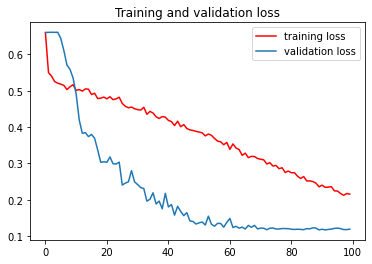

In [21]:
# Retrieve a list of list results on training and test data sets for each training epoch
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(loss))
# Plot training and validation loss per epoch
plt.plot(epochs,loss, color='red' , label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title ('Training and validation loss')

#### **Test the model on random images**

In [22]:
scalers_dict

{'mouth_center_top_lip_x': MinMaxScaler(),
 'mouth_center_top_lip_y': MinMaxScaler()}

[0.4801896  0.41992384]
[46.882984 72.60448 ]
[[0.48604318 0.4324597 ]]
[[47.300835 73.0787  ]]


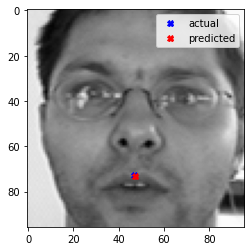

In [23]:
batch = val_generator.__getitem__(2)
j= np.random.randint(0,len(batch[0]))
# check original image 
print(batch[1][j:j+1][0])
actual_y= batch[1][j:j+1][0]
actual_y[0] = scalers_dict[feature_name+"_x"].inverse_transform([[actual_y[0]]])
actual_y[1] = scalers_dict[feature_name+"_y"].inverse_transform([[actual_y[1]]])
print(actual_y)
##############################################
predicted_y = model.predict(batch[0][j:j+1])
print(predicted_y)
# uncomment in case we have used the scaling
predicted_y[:,:1] = scalers_dict[feature_name+"_x"].inverse_transform(predicted_y[:,:1])
predicted_y[:,1:] = scalers_dict[feature_name+"_y"].inverse_transform(predicted_y[:,1:])
print(predicted_y)
##############################################3
visualize_image(batch[0][j:j+1].reshape(96,96,3)[:,:,0],actual_y, predicted_y[0])

**Its very impressive how close are the predicted corrdinates to the original ones**

#### **Test on missing data**

In [24]:
feature_name

'mouth_center_top_lip'

In [25]:
rgb_channels= True
normalize_image = True
def pre_process_images(image):
    image = np.vstack(image).reshape(-1, 96, 96, 1).astype(np.float32)
    if rgb_channels:
        image = np.repeat(image,3,-1)
    if normalize_image == True:
        image = image/255
    return image

In [26]:
missing_data = dic_missing_data[feature_name]

In [27]:
len(missing_data)

4774

[[0.48748636 0.4335712 ]]
[[47.403854 73.12074 ]]


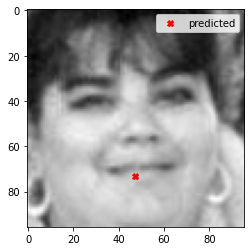

In [28]:
# take a random image and test on it
l = np.random.randint(0, len(missing_data)-1)
image = missing_data.iloc[l]["Image"]
image = pre_process_images(image)
predicted_y = model.predict(image)
print(predicted_y)
# uncomment in case we have used the scaling
predicted_y[:,:1] = scalers_dict[feature_name+"_x"].inverse_transform(predicted_y[:,:1])
predicted_y[:,1:] = scalers_dict[feature_name+"_y"].inverse_transform(predicted_y[:,1:])
print(predicted_y)
visualize_image(image.reshape(96,96,3)[:,:,0],None, predicted_y[0])

#### **Save model**

In [29]:
# save model and architecture to single file
model.save(model_path)